# Preprocessing

### In questa sezione viene effettuato il preprocessing del dataset
### Import delle librerie e moduli necessari

In [1]:
# librerie generali
import pandas as pd
import numpy as np

# librerie per grafici
import matplotlib.pyplot as plt
import seaborn as sns

# librerie per text processing
import string
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# librerie per WordCLoud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

# Panoramica del dataset

Abbiamo caricato il dataset in locale

In [2]:
df = pd.read_csv("datasets/winemag-data.csv")

df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# Pulizia dei dati
## Fase 1
Di seguito abbiamo deciso di eliminare, con il comando drop, le colonne che riteniamo non necessarie

In [3]:
#Riduciamo inoltre il numero di righe del database in modo da poter velocizzare il processo
clean_df = df.drop(columns=['Unnamed: 0','designation','region_1','region_2','taster_name','taster_twitter_handle'],inplace=False).head(5000)
clean_df.head()

,country,description,points,price,province,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Abbiamo individuato eventuali valori mancanti e successivamente li abbiamo eliminati dal dataset

In [4]:
# trova valori nulli
print(clean_df.isnull().sum())

country          3
description      0
points           0
price          343
province         3
title            0
variety          0
winery           0
dtype: int64


<Axes: >

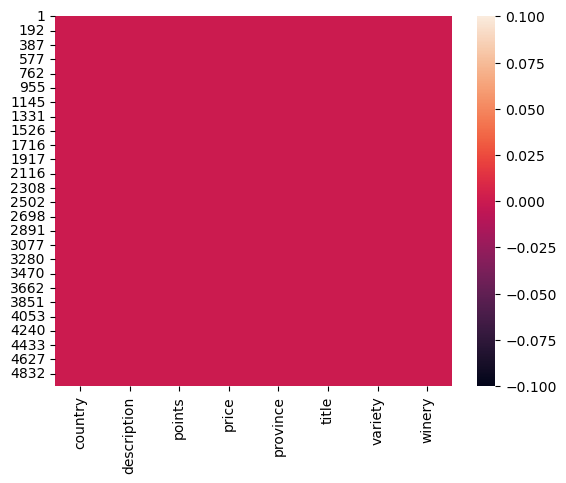

In [5]:
# elimina le righe che contengono valori nulli
clean_df.dropna(axis='index', how='any', inplace=True)

# heatmap per valori nulli
sns.heatmap(clean_df.isnull())

#### Dimensione del dataset processato

In [6]:
print('Dimensione del dataset processato: ', clean_df.shape)

Dimensione del dataset processato:  (4655, 8)


## Fase 2

## Normalizzazione e Standardizzazione

### In questa fase viene effettuato un processo di text cleaning delle colonne 'description', 'province', 'title', 'variety' e 'winery'. In particolare verranno eseguite le seguenti operazioni:
- Rimozione delle stopwords
- Rimozione dei segni di punteggiatura
- Lowering del testo
- Lemmatizzazione del testo

In [7]:
#Rimozione delle stopwords
def remove_stopwords(text):
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

#Rimozione dei segni di punteggiatura
def remove_punctuation(text):
    PUNCTUATION = string.punctuation
    return text.translate(str.maketrans('', '', PUNCTUATION))

#Lowering del testo
def text_lowerer(dataframe, column):
    dataframe[column] = dataframe[column].str.lower()
    return dataframe

#Lemmatizzazione del testo
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

## 2.1 Text processing della colonna 'description'

In [8]:
# Rimozione delle stopword
clean_df["description"] = clean_df["description"].apply(lambda text: remove_stopwords(text))

# Rimozione dei segni di punteggiatura
clean_df["description"] = clean_df["description"].apply(lambda text: remove_punctuation(text))

# Lowering del testo
clean_df = text_lowerer(clean_df, "description")

# lemmatizzazione delle parole
clean_df["description"] = clean_df["description"].apply(lambda text: lemmatize_words(text))

# rimozione delle stopword dopo lemmatizzazione
clean_df["description"] = clean_df["description"].apply(lambda text: remove_stopwords(text))

clean_df.head()

,country,description,points,price,province,title,variety,winery
1,Portugal,ripe fruity wine smooth still structure firm t...,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,tart snappy flavor lime flesh rind dominate gr...,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,pineapple rind lemon pith orange blossom start...,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,much like regular bottling 2012 come across ra...,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,blackberry raspberry aromas show typical navar...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


## 2.2 Text processing della colonna 'title'

In [9]:
# Rimozione delle stopword
clean_df["title"] = clean_df["title"].apply(lambda text: remove_stopwords(text))

# Rimozione dei segni di punteggiatura
clean_df["title"] = clean_df["title"].apply(lambda text: remove_punctuation(text))

# Lowering del testo
clean_df = text_lowerer(clean_df, "title")

# lemmatizzazione delle parole
clean_df["title"] = clean_df["title"].apply(lambda text: lemmatize_words(text))

# rimozione delle stopword dopo lemmatizzazione
clean_df["title"] = clean_df["title"].apply(lambda text: remove_stopwords(text))

clean_df.head()

,country,description,points,price,province,title,variety,winery
1,Portugal,ripe fruity wine smooth still structure firm t...,87,15.0,Douro,quinta avidagos 2011 avidagos red douro,Portuguese Red,Quinta dos Avidagos
2,US,tart snappy flavor lime flesh rind dominate gr...,87,14.0,Oregon,rainstorm 2013 pinot gris willamette valley,Pinot Gris,Rainstorm
3,US,pineapple rind lemon pith orange blossom start...,87,13.0,Michigan,st julian 2013 reserve late harvest riesling l...,Riesling,St. Julian
4,US,much like regular bottling 2012 come across ra...,87,65.0,Oregon,sweet cheek 2012 vintner reserve wild child bl...,Pinot Noir,Sweet Cheeks
5,Spain,blackberry raspberry aromas show typical navar...,87,15.0,Northern Spain,tandem 2011 ar vitro tempranillomerlot navarra,Tempranillo-Merlot,Tandem


## 2.3 Text processing della colonna 'variety'

In [10]:
# Rimozione delle stopword
clean_df["variety"] = clean_df["variety"].apply(lambda text: remove_stopwords(text))

# Lowering del testo
clean_df = text_lowerer(clean_df, "variety")

# lemmatizzazione delle parole
clean_df["variety"] = clean_df["variety"].apply(lambda text: lemmatize_words(text))

# rimozione delle stopword dopo lemmatizzazione
clean_df["variety"] = clean_df["variety"].apply(lambda text: remove_stopwords(text))

clean_df.head()

,country,description,points,price,province,title,variety,winery
1,Portugal,ripe fruity wine smooth still structure firm t...,87,15.0,Douro,quinta avidagos 2011 avidagos red douro,portuguese red,Quinta dos Avidagos
2,US,tart snappy flavor lime flesh rind dominate gr...,87,14.0,Oregon,rainstorm 2013 pinot gris willamette valley,pinot gris,Rainstorm
3,US,pineapple rind lemon pith orange blossom start...,87,13.0,Michigan,st julian 2013 reserve late harvest riesling l...,riesling,St. Julian
4,US,much like regular bottling 2012 come across ra...,87,65.0,Oregon,sweet cheek 2012 vintner reserve wild child bl...,pinot noir,Sweet Cheeks
5,Spain,blackberry raspberry aromas show typical navar...,87,15.0,Northern Spain,tandem 2011 ar vitro tempranillomerlot navarra,tempranillo-merlot,Tandem


## Fase 3
### Eliminazione dei duplicati
In questo dataset sono presenti fin troppi duplicati. Abbiamo notato che il comando df.drop_duplicates() non bastava per eliminarli tutti e non restituiva i valori attesi. Tuttavia, notando che la colonna "description" presentasse valori identici dimostrava che non si trattassero di recensioni diverse.

In [11]:
clean_df[clean_df.duplicated('description',keep=False)].sort_values('description').head(5)

,country,description,points,price,province,title,variety,winery
3432,US,aroma light note freshly cut apple spice drink...,88,27.0,Washington,analemma 2014 atavus vineyard gewürztraminer c...,gewürztraminer,Analemma
3059,US,aroma light note freshly cut apple spice drink...,88,27.0,Washington,analemma 2014 atavus vineyard gewürztraminer c...,gewürztraminer,Analemma
53,France,fruity lightly herbaceous fine textured acidit...,85,15.0,Bordeaux,château de sour 2011 la fleur damélie bordeaux...,bordeaux-style white blend,Château de Sours
2413,France,fruity lightly herbaceous fine textured acidit...,85,15.0,Bordeaux,château de sour 2011 la fleur damélie bordeaux...,bordeaux-style white blend,Château de Sours
3430,US,inaugural vintage wine name water goddess offe...,86,26.0,California,stag leap wine cellar 2013 aveta sauvignon bla...,sauvignon blanc,Stag's Leap Wine Cellars


Eliminiamo quindi le recensioni duplicate basandoci sulla colonna "description"

In [12]:
clean_df = clean_df.drop_duplicates('description')
clean_df.shape

(4641, 8)

## Creazione della colonna "year"
Procediamo alla creazione di una nuova colonna per poter distinguere l'anno di produzione di un vino dal suo nome (colonna "title")

In [13]:
#Copiamo la colonna title rimuovendo i caratteri non numerici per creare la colonna year
clean_df['year'] = clean_df.loc[:, 'title'].str.replace('\D', '', regex=True)

#Eliminiamo dalla colonna title tutti i caratteri numerici
clean_df['title'] = clean_df['title'].str.replace('\d+', '', regex=True)

clean_df.head()

,country,description,points,price,province,title,variety,winery,year
1,Portugal,ripe fruity wine smooth still structure firm t...,87,15.0,Douro,quinta avidagos avidagos red douro,portuguese red,Quinta dos Avidagos,2011
2,US,tart snappy flavor lime flesh rind dominate gr...,87,14.0,Oregon,rainstorm pinot gris willamette valley,pinot gris,Rainstorm,2013
3,US,pineapple rind lemon pith orange blossom start...,87,13.0,Michigan,st julian reserve late harvest riesling lake ...,riesling,St. Julian,2013
4,US,much like regular bottling 2012 come across ra...,87,65.0,Oregon,sweet cheek vintner reserve wild child block ...,pinot noir,Sweet Cheeks,2012
5,Spain,blackberry raspberry aromas show typical navar...,87,15.0,Northern Spain,tandem ar vitro tempranillomerlot navarra,tempranillo-merlot,Tandem,2011


## Target feature processing

In [14]:
clean_df.variety.value_counts()

pinot noir                  454
chardonnay                  410
cabernet sauvignon          367
red blend                   331
bordeaux-style red blend    226
                           ... 
savagnin                      1
turbiana                      1
refosco                       1
malbec-cabernet franc         1
pallagrello                   1
Name: variety, Length: 258, dtype: int64

In [15]:
filtered_name = ['red blend', 'portuguese red', 'white blend', 'sparkling blend', 'champagne blend', 
                 'portuguese white', 'rose', 'bordeaux-style red blend', 'rhone-style red blend',
                 'bordeaux-style white blend', 'alsace white blend', 'austrian red blend',
                 'austrian white blend', 'cabernet blend', 'malbec blend', 'portuguese rose',
                 'portuguese sparkling', 'provence red blend', 'provence white blend',
                 'rhone-style white blend', 'tempranillo blend', 'grenache blend',
                 'meritage'
                ]
clean_df = clean_df[~clean_df['variety'].isin(filtered_name)]

In [16]:
import re

def correct_grape_names(row):
    regexp = [r'shiraz', r'ugni blanc', r'cinsaut', r'carinyena', r'^ribolla$', r'palomino', r'turbiana', r'verdelho', r'viura', r'pinot bianco|weissburgunder', r'garganega|grecanico', r'moscatel', r'moscato', r'melon de bourgogne', r'trajadura|trincadeira', r'cannonau|garnacha', r'grauburgunder|pinot grigio', r'pinot noir|pinot nero', r'colorino', r'mataro|monastrell', r'mourv(\w+)']
    grapename = ['syrah', 'trebbiano', 'cinsault', 'carignan', 'ribolla gialla', 'palomino','verdicchio', 'verdejo','macabeo', 'pinot blanc', 'garganega', 'muscatel', 'muscat', 'muscadet', 'treixadura', 'grenache', 'pinot gris', 'pinot noir', 'lambrusco', 'mourvedre', 'mourvedre']
    f = row
    for exsearch, gname in zip(regexp, grapename):
        f = re.sub(exsearch, gname, f)
    return f

name_pairs = [('spatburgunder', 'pinot noir'), ('garnacha', 'grenache'), ('pinot nero', 'pinot noir'),
              ('alvarinho', 'albarino'), ('assyrtico', 'assyrtiko'), ('black muscat', 'muscat hamburg'),
              ('kekfrankos', 'blaufrankisch'), ('garnacha blanca', 'grenache blanc'),
              ('garnacha tintorera', 'alicante bouschet'), ('sangiovese grosso', 'sangiovese')
             ]
clean_df['variety'] = clean_df['variety'].apply(lambda row: correct_grape_names(row))
for start, end in name_pairs:
    clean_df['variety'] = clean_df['variety'].replace(start, end) 
len(clean_df.variety.value_counts())

227

In [17]:
clean_df = clean_df.groupby('variety').filter(lambda x: len(x) > 200)
clean_df.shape

(1239, 9)

## Creazione delle colonne red e white

In [18]:
colour_map = {'aglianico': 'red', 'albarino': 'white', 'barbera': 'red', 'cabernet franc': 'red',
              'cabernet sauvignon': 'red', 'carmenere': 'red', 'chardonnay': 'white', 'chenin blanc': 'white',
              'corvina, rondinella, molinara': 'red', 'gamay': 'red', 'garganega': 'white', 
              'gewurztraminer': 'white', 'glera': 'white', 'grenache': 'red', 'gruner veltliner': 'white',
              'malbec': 'red', 'merlot': 'red', 'mourvedre': 'red', 'muscat': 'white', 'nebbiolo': 'red',
              "nero d'avola": 'red', 'petite sirah': 'red', 'pinot blanc': 'white', 'pinot gris': 'white',
              'pinot noir': 'red', 'port': 'red', 'prosecco': 'white', 'riesling': 'white', 'sangiovese': 'red',
              'sauvignon blanc': 'white', 'syrah': 'red', 'tempranillo': 'red', 'torrontes': 'white', 
              'verdejo': 'white', 'viognier': 'white', 'zinfandel': 'white'
             }

In [19]:
clean_df['colour'] = clean_df.apply(lambda row: colour_map[row['variety']], axis=1)
colour_dummies = pd.get_dummies(clean_df['colour'])
clean_df = clean_df.merge(colour_dummies, left_index=True, right_index=True)
clean_df.reset_index(inplace=True)
clean_df.head()

,index,country,description,points,price,province,title,variety,winery,year,colour,red,white
0,4,US,much like regular bottling 2012 come across ra...,87,65.0,Oregon,sweet cheek vintner reserve wild child block ...,pinot noir,Sweet Cheeks,2012,red,1,0
1,10,US,soft supple plum envelop oaky structure cabern...,87,19.0,California,kirkland signature mountain cuvée cabernet sa...,cabernet sauvignon,Kirkland Signature,2011,red,1,0
2,12,US,slightly reduce wine offer chalky tannic backb...,87,34.0,California,louis martini cabernet sauvignon alexander va...,cabernet sauvignon,Louis M. Martini,2012,red,1,0
3,14,US,build 150 year six generation winemaking tradi...,87,12.0,California,mirassou chardonnay central coast,chardonnay,Mirassou,2012,white,0,1
4,21,US,sleek mix tart berry stem herb along hint oak ...,87,20.0,Oregon,acrobat pinot noir oregon,pinot noir,Acrobat,2013,red,1,0


## Fase 4
### Distribuzione punteggio
Un'aspetto interessante del database è la distribuzione dei punteggi. Questi sono dati dai recensori e vanno da 80 a 100. WineEnthusiast classifica inoltre questi punteggi in 5 categorie:
- 80–82: ACCEPTABLE Può essere considerato
- 83–86: GOOD Adatto per la consumazione giornaliera
- 87–89: VERY GOOD Spesso di buon valore, molto consigliato
- 90–93: EXCELLENT Altamente consigliato
- 94–97: SUPERB Di pregevole qualità
- 98–100: CLASSIC L'apice della qualità

Creamo quindi una nuova colonna chiamata "points_description" contenente la descrizione dei punteggi

In [20]:
def pointsDispacher(points):
    if points < 83:
        val = 'Acceptable'
    elif points < 87:
        val = 'Good'
    elif points < 90:
        val = 'Very good'
    elif points < 93:
        val = 'Excellent'
    elif points < 97:
        val = 'Superb'
    else:
        val = 'Classic'

    return val

#Create new column with points description
clean_df['points_description'] = clean_df['points'].map(pointsDispacher)

Text(0, 0.5, 'Count')

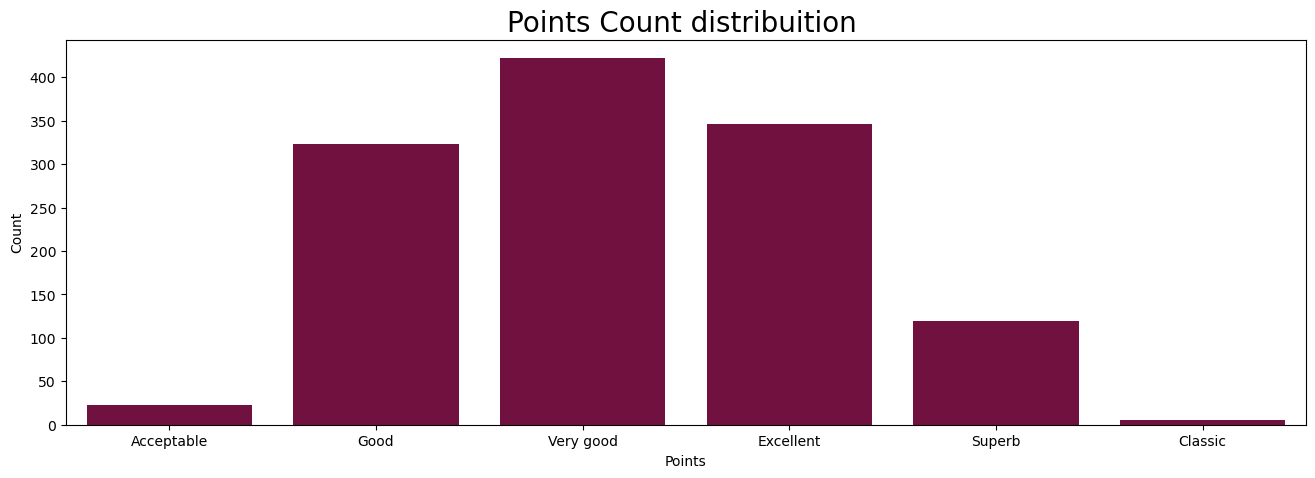

In [21]:
#Istogramma della descrizione dei punti
plt.figure(figsize=(16,5))

g = sns.countplot(x='points_description', data=clean_df, color = sns.xkcd_rgb['wine'], order = ['Acceptable', 'Good', 'Very good', 'Excellent', 'Superb', 'Classic'])
g.set_title("Points Count distribuition ", fontsize=20) 
g.set_xlabel("Points") 
g.set_ylabel("Count")

Inoltre, notiamo dal grafico seguente come esiste una relazione tra la lunghezza della descrizione e i punti del vino. In particolare, il punteggio del vino tende ad aumentare in modo direttamente proporzionale alla lunghezza della descrizione

In [22]:
clean_df['description_length'] = clean_df['description'].apply(lambda x: len(x))

<Axes: xlabel='points', ylabel='description_length'>

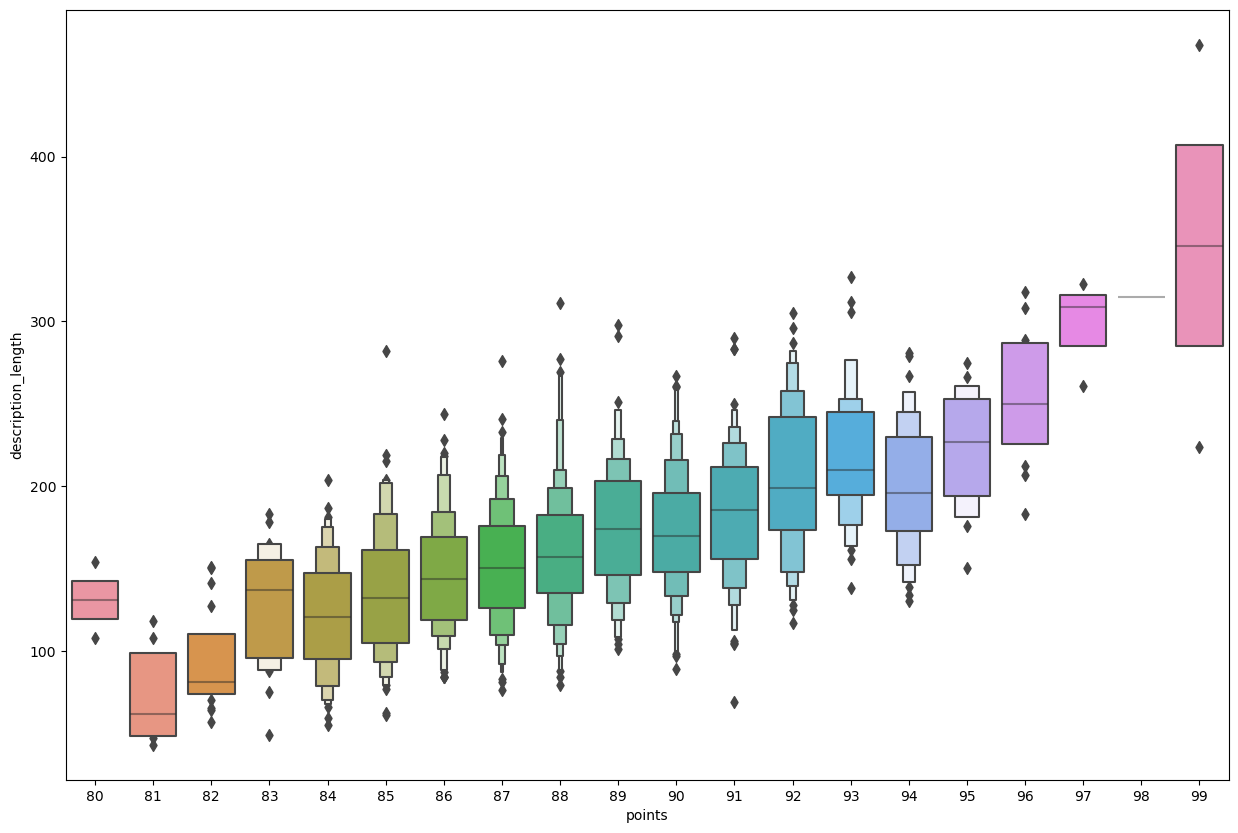

In [23]:
plt.figure(figsize=(15, 10))
sns.boxenplot(data = clean_df, x="points", y="description_length", k_depth="trustworthy")

## WordCloud

In [24]:
text = " ".join(review for review in clean_df.description)   # unisce tutte le descrizioni
stopwords = set(STOPWORDS)

In [25]:
custom_mask = np.array(Image.open('Img/wine_wordcloud.jpg'))
wc = WordCloud(background_color = 'white', stopwords = stopwords, mask = custom_mask)
wc.generate(text)

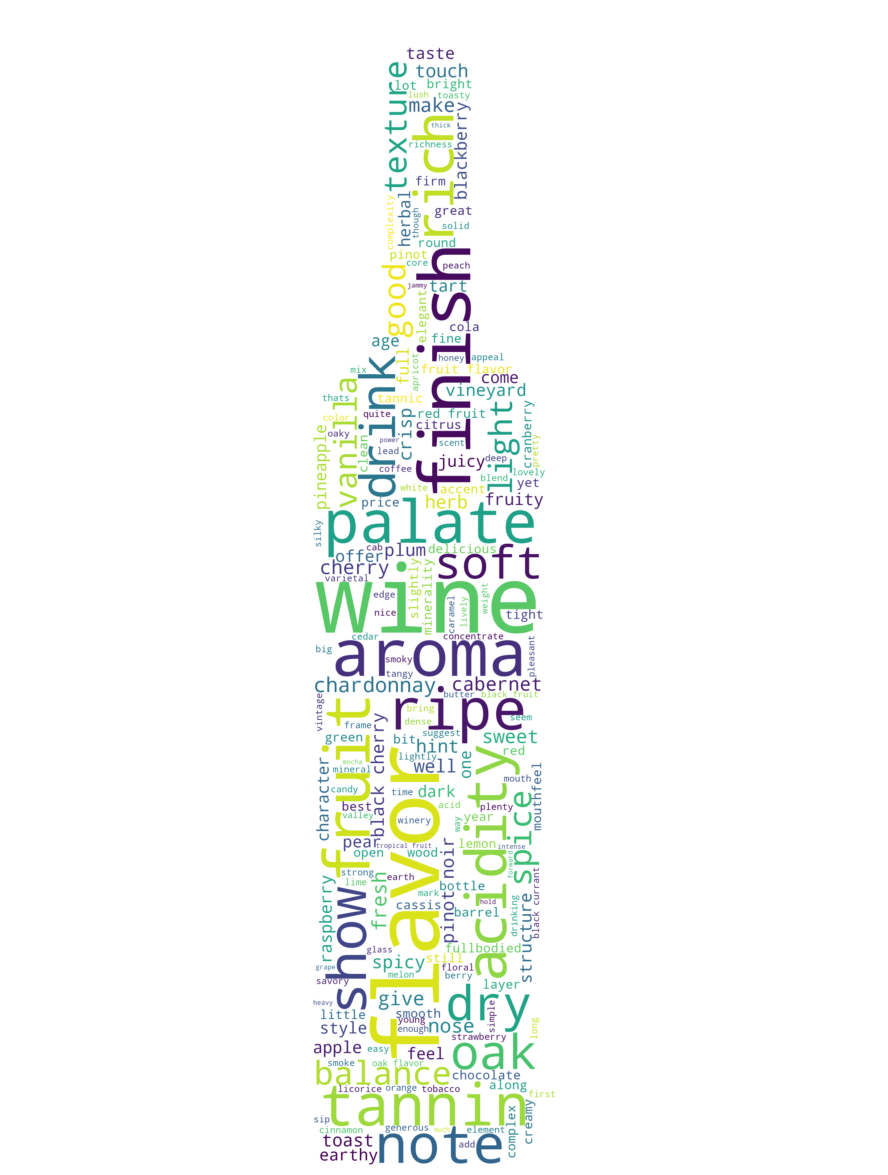

In [26]:
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Divisione del dataset
Dividiamo il dataset in set training e set di test

In [27]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
clean_df["new_Variety"] = ord_enc.fit_transform(clean_df[["variety"]])

clean_df["new_Country"] = ord_enc.fit_transform(clean_df[["country"]])

clean_df["new_Winery"] = ord_enc.fit_transform(clean_df[["winery"]])

clean_df.head()

,index,country,description,points,price,province,title,variety,winery,year,colour,red,white,points_description,description_length,new_Variety,new_Country,new_Winery
0,4,US,much like regular bottling 2012 come across ra...,87,65.0,Oregon,sweet cheek vintner reserve wild child block ...,pinot noir,Sweet Cheeks,2012,red,1,0,Very good,183,2.0,15.0,816.0
1,10,US,soft supple plum envelop oaky structure cabern...,87,19.0,California,kirkland signature mountain cuvée cabernet sa...,cabernet sauvignon,Kirkland Signature,2011,red,1,0,Very good,184,0.0,15.0,450.0
2,12,US,slightly reduce wine offer chalky tannic backb...,87,34.0,California,louis martini cabernet sauvignon alexander va...,cabernet sauvignon,Louis M. Martini,2012,red,1,0,Very good,136,0.0,15.0,511.0
3,14,US,build 150 year six generation winemaking tradi...,87,12.0,California,mirassou chardonnay central coast,chardonnay,Mirassou,2012,white,0,1,Very good,233,1.0,15.0,574.0
4,21,US,sleek mix tart berry stem herb along hint oak ...,87,20.0,Oregon,acrobat pinot noir oregon,pinot noir,Acrobat,2013,red,1,0,Very good,163,2.0,15.0,4.0


In [28]:
from sklearn.model_selection import train_test_split

combined_features = ['description', 'white', 'red']
target = 'variety'

X_train, X_test, y_train, y_test = train_test_split(clean_df[combined_features], clean_df[target], test_size=0.33, random_state=42, stratify=clean_df[target])

## Rappresentazione Tf-Idf

In [29]:
#####description = clean_df['description'].to_numpy()
####vectorizer = TfidfVectorizer(sublinear_tf=True)
###tfidf_vector = vectorizer.fit_transform(description)
##clean_df = pd.DataFrame(tfidf_vector.toarray(), index=description, columns=vectorizer.get_feature_names_out())

#print(clean_df.shape)

# Costruzione dei modelli e addestramento
## Classificazione con naive bayes

In [30]:
X = clean_df[combined_features].copy()
clean_df[combined_features]

,description,white,red
0,much like regular bottling 2012 come across ra...,0,1
1,soft supple plum envelop oaky structure cabern...,0,1
2,slightly reduce wine offer chalky tannic backb...,0,1
3,build 150 year six generation winemaking tradi...,1,0
4,sleek mix tart berry stem herb along hint oak ...,0,1
...,...,...,...
1234,tolosa may vineyard produce two unoaked chardo...,1,0
1235,ripe forward flavor raspberries cherry cola ma...,0,1
1236,fresh fruity charm rosé offer fullbodied flavo...,0,1
1237,torre pieve thick creamy chardonnay half age o...,1,0
